# Regresión Lineal Múltiple y LASSO

### Students grades

[Source Information](https://www.kaggle.com/hely333/what-is-the-secret-of-academic-success/data)
P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.

In [1]:
# Se cargan las librerías que se van a utilizar
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale

In [2]:
pd.set_option('display.max_columns', 33) # by default is 10, if change to None print ALL

In [3]:
## 1) EXTRAER DATOS
df = pd.read_csv('student_mat.csv')
print(df.shape)

(395, 33)


In [4]:
## 2) ANÁLISIS EXPLORATORIO
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


Los datos corresponden a 395 estudiantes de 15 a 22 años que están en un curso de Matemáticas.

La información que se tiene de cada uno de los estudiantes es (33 columnas):

   - **school :** _GP:_ Gabriel Pereira, _MS:_ Mousinho da Silveira
   - **sex:** _F:_ female, _M:_ male
   - **age:** student's age (15-22)
   - **address:** _U:_ urban, _R:_ rural
   - **famsize:**  'LE3' - less or equal to 3 or 'GT3' - greater than 3
   - **Pstatus:** 'T' - living together or 'A' - apart
   - **Medu:** mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
   - **Fedu:** father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
   - **Mjob:** mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
   - **Fjob:** father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
   - **reason:** reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
   - **guardian:** student's guardian (nominal: 'mother', 'father' or 'other')
   - **traveltime:** home to school travel time (numeric: 1 - 4 hours)
   - **studytime:** weekly study time (numeric: 1 - 10 hours)
   - **failures:** number of past class failures (numeric: n if 1<=n<3, else 4)
   - **schoolsup:** extra educational support (binary: yes or no)
   - **famsup:** family educational support (binary: yes or no)
   - **paid:** extra paid classes within the course subject (Math) (binary: yes or no)
   - **activities:** extra-curricular activities (binary: yes or no)
   - **nursery:** attended nursery school (binary: yes or no)
   - **higher:** wants to take higher education (binary: yes or no)
   - **internet:** Internet access at home (binary: yes or no)
   - **romantic:** with a romantic relationship (binary: yes or no)
   - **famrel:** quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
   - **freetime:** free time after school (numeric: from 1 - very low to 5 - very high)
   - **goout:** going out with friends (numeric: from 1 - very low to 5 - very high)
   - **Dalc:** workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
   - **Walc:** weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
   - **health:** current health status (numeric: from 1 - very bad to 5 - very good)
   - **absences:** number of school absences (numeric: from 0 to 93)
   - **G1:** first period grade (numeric: from 0 to 20)
   - **G2:** second period grade (numeric: from 0 to 20)
   - **G3:** final grade (numeric: from 0 to 20, output target)
 

#### Se busca estimar la calificación final: _G3_.

<!---
   - **school :** Escuela a la que pertenecen los estudiantes. _GP:_ Gabriel Pereira, _MS:_ Mousinho da Silveira.
   - **sex:** _F:_ femenino, _M:_ masculino.
   - **age:** Variable numérica (15-22).
   - **address:** _U:_ Zona urbana, _R:_ Zona rural.
   - **famsize:** Tamaño de la familia. _LE3:_ Si <= 3, _GT3:_ Si >3.
   - **Pstatus:** T: Si vive con sus padres, A: Si vive aparte.
   - **Medu:** Educación de la madre. 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education
   - **Fedu:** Educación del padre.


https://www.kaggle.com/gemartin/average-ensemble-optimization
-->

In [ ]:
# Se cuenta el número de NaN's por columna
df.isnull().sum()

In [5]:
# Se definen las varibles X (predictoras) y Y (dependiente)
Y = df.G3
X = df.drop(['G3'], axis = 1)
X.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10


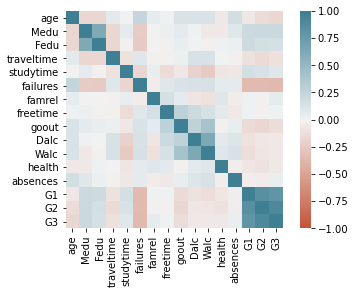

In [6]:
# Matriz de correlación
corr = df.corr()
#corr
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

Antes de convertir las variables categóricas a variables dummies, vamos a ver algunas gráficas para decidir cuáles vamos a utilizar en la regresión.

In [ ]:
## 3) VISUALIZACIÓN DE LOS DATOS
#Histograma de la frecuencia relativa del salario con la densidad ajustada correspondiente.
sns.distplot(Y)
plt.title('Histograma de la frecuencia relativa de las calificaciones')
plt.xlabel('Calificaciones')
plt.ylabel('Frecuencia relativa')

In [ ]:
print(df['sex'].value_counts())
sns.countplot(x='sex', data=df)
plt.show()

In [ ]:
print(df['age'].value_counts())
sns.countplot(x='age', data=df)
plt.show()

In [ ]:
print(df['address'].value_counts())
sns.countplot(x='address', data=df)
plt.show()

In [ ]:
sns.countplot(x='age', hue='Pstatus', data=df)
plt.title('Estudiantes viviendo con o sin sus padres por edad')
plt.xlabel('A = No viven con sus padres, T = Si viven con sus padres')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
# numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education
print(df['Medu'].value_counts())
sns.countplot(x='Medu', data=df)
plt.show()

In [ ]:
# numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education
print(df['Fedu'].value_counts())
sns.countplot(x='Fedu', data=df)
plt.show()

In [ ]:
# (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
print(df['Mjob'].value_counts())
sns.countplot(x='Mjob', data=df)
plt.show()

In [ ]:
# (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
print(df['Fjob'].value_counts())
sns.countplot(x='Fjob', data=df)
plt.show()

In [ ]:
# numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education
sns.countplot(x='Mjob', hue='Medu', data=df)
plt.title('Trabajo y educación de las mamás de los estudiantes')
plt.xlabel('Trabajo')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
sns.countplot(x='Fjob', hue='Fedu', data=df)
plt.title('Trabajo y educación de los papás de los estudiantes')
plt.xlabel('Trabajo')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
# reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
print(df['reason'].value_counts())
sns.countplot(x='reason', data=df)
plt.show()

In [ ]:
print(df['guardian'].value_counts())
sns.countplot(x='guardian', data=df)
plt.show()

In [ ]:
sns.countplot(x='guardian', hue='age', data=df)
plt.title('Guardianes de los estudiantes')
plt.xlabel('Guardián')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
sns.countplot(x='traveltime', hue='address', data=df)
plt.title('Horas de camino por lugar de residencia')
plt.xlabel('U = Zona Urbana, R = Zona Rural')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
sns.countplot(x='studytime', hue='address', data=df)
plt.title('Horas de estudio por lugar de residencia')
plt.xlabel('U = Zona Urbana, R = Zona Rural')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
print(df['failures'].value_counts())
sns.countplot(x='failures', data=df)
plt.show()

In [ ]:
sns.countplot(x='age', hue='failures', data=df)
plt.title('Número de clases reprobadas por edad')
plt.xlabel('Edad')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
print(df['schoolsup'].value_counts())
sns.countplot(x='schoolsup', data=df)
plt.show()

In [ ]:
print(df['famsup'].value_counts())
sns.countplot(x='famsup', data=df)
plt.show()

In [ ]:
print(df['paid'].value_counts())
sns.countplot(x='paid', data=df)
plt.show()

In [ ]:
print(df['activities'].value_counts())
sns.countplot(x='activities', data=df)
plt.show()

In [ ]:
sns.countplot(x='address', hue='activities', data=df)
plt.title('Actividades por lugar de residencia')
plt.xlabel('U = Zona Urbana, R = Zona Rural')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
print(df['nursery'].value_counts())
sns.countplot(x='nursery', data=df)
plt.show()

In [ ]:
print(df['higher'].value_counts())
sns.countplot(x='higher', data=df)
plt.show()

In [ ]:
sns.countplot(x='address', hue='internet', data=df)
plt.title('Internet por lugar de residencia')
plt.xlabel('U = Zona Urbana, R = Zona Rural')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
sns.countplot(x='age', hue='romantic', data=df)
plt.title('Estudiantes con o sin relación amorosa por edad')
plt.xlabel('Edad')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
sns.countplot(x='age', hue='famrel', data=df)
plt.title('Calidad de la relación familiar por edad')
plt.xlabel('Edad')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
sns.countplot(x='address', hue='freetime', data=df)
plt.title('Tiempo libre por lugar de residencia')
plt.xlabel('U = Zona Urbana, R = Zona Rural')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
#going out with friends (numeric: from 1 - very low to 5 - very high)
#free time after school (numeric: from 1 - very low to 5 - very high)
sns.countplot(x='goout', hue='freetime', data=df)
plt.title('Salir con amigos por Tiempo libre')
plt.xlabel('Salir con amigos')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
#going out with friends (numeric: from 1 - very low to 5 - very high)
sns.countplot(x='age', hue='goout', data=df)
plt.title('Salir con amigos por Edad')
plt.xlabel('Edad')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
#workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
print(df['Dalc'].value_counts())
sns.countplot(x='Dalc', data=df)
plt.show()

In [ ]:
#weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
print(df['Walc'].value_counts())
sns.countplot(x='Walc', data=df)
plt.show()

In [ ]:
#workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
sns.countplot(x='age', hue='Dalc', data=df)
plt.title('Consumo de alcohol entre semana por Edad')
plt.xlabel('Edad')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
#weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
sns.countplot(x='age', hue='Walc', data=df)
plt.title('Consumo de alcohol en fin de semana por Edad')
plt.xlabel('Edad')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
#current health status (numeric: from 1 - very bad to 5 - very good)
print(df['health'].value_counts())
sns.countplot(x='health', data=df)
plt.show()

In [ ]:
sns.boxplot(x="absences", data=df)

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(orient="h",data=df[['G1','G2']])
plt.title('Gráficas de caja de calificaciones')
plt.xlabel('Calificaciones')

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Calificaciones del primer parcial de acuerdo a las horas de estudio")
sns.boxplot(y="studytime", x="G1", data = df , orient="h")

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Calificaciones del segundo parcial de acuerdo a las horas de estudio")
sns.boxplot(y="studytime", x="G2", data = df , orient="h")

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Calificaciones finales de acuerdo a las personas que quieren o no seguir estudiando")
sns.boxplot(y="higher", x="G3", data = df , orient="h")

In [ ]:
#weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
#going out with friends (numeric: from 1 - very low to 5 - very high)
sns.countplot(x='goout', hue='Dalc', data=df)
plt.title('Consumo de alcohol entre semana por salidas con amigos')
plt.xlabel('Salir con amigos')
plt.ylabel('Número de estudiantes')
plt.show()

In [ ]:
#weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
sns.countplot(x='goout', hue='Walc', data=df)
plt.title('Consumo de alcohol en fin de semana por salidas con amigos')
plt.xlabel('Salir con amigos')
plt.ylabel('Número de estudiantes')
plt.show()

In [7]:
# Se eliminan las columnas algunas columnas:
print('Antes se tenían ',X.shape[1],' columnas.')

X = X.drop(['school','sex','famsize','Medu','Fedu','Mjob','Fjob','reason','guardian','nursery','higher','famrel'], axis = 1)

print('Ahora se tienen ',X.shape[1],' columnas.')
X.head()

Antes se tenían  32  columnas.
Ahora se tienen  20  columnas.


,age,address,Pstatus,traveltime,studytime,failures,schoolsup,famsup,paid,activities,internet,romantic,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,18,U,A,2,2,0,yes,no,no,no,no,no,3,4,1,1,3,6,5,6
1,17,U,T,1,2,0,no,yes,no,no,yes,no,3,3,1,1,3,4,5,5
2,15,U,T,1,2,3,yes,no,yes,no,yes,no,3,2,2,3,3,10,7,8
3,15,U,T,1,3,0,no,yes,yes,yes,yes,yes,2,2,1,1,5,2,15,14
4,16,U,T,1,2,0,no,yes,yes,no,no,no,3,2,1,2,5,4,6,10


In [8]:
X.describe()

,age,traveltime,studytime,failures,freetime,goout,Dalc,Walc,health,absences,G1,G2
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,1.448101,2.035443,0.334177,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924
std,1.276043,0.697505,0.839240,0.743651,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505
min,15.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000
25%,16.000000,1.000000,1.000000,0.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000
50%,17.000000,1.000000,2.000000,0.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000
75%,18.000000,2.000000,2.000000,0.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000
max,22.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000


In [9]:
#Se definen las variables dummies para las variables categóricas
dummies = pd.get_dummies(X[['address', 'Pstatus', 'schoolsup','famsup','paid','activities','internet','romantic']])
dummies.head()

,address_R,address_U,Pstatus_A,Pstatus_T,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0
1,0,1,0,1,1,0,0,1,1,0,1,0,0,1,1,0
2,0,1,0,1,0,1,1,0,0,1,1,0,0,1,1,0
3,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1
4,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,0


In [10]:
#Se reemplazan por las variables dummies
X = X.drop(['address', 'Pstatus', 'schoolsup','famsup','paid','activities','internet','romantic'], axis = 1).astype('float64')
X = pd.concat([X, dummies[['address_U', 'Pstatus_T', 'schoolsup_yes','famsup_yes','paid_yes','activities_yes',
                           'internet_yes','romantic_yes']]], axis = 1)

print(X.shape[0],' renglones\n',X.shape[1],' columnas')
X.head()

395  renglones
 20  columnas


,age,traveltime,studytime,failures,freetime,goout,Dalc,Walc,health,absences,G1,G2,address_U,Pstatus_T,schoolsup_yes,famsup_yes,paid_yes,activities_yes,internet_yes,romantic_yes
0,18.0,2.0,2.0,0.0,3.0,4.0,1.0,1.0,3.0,6.0,5.0,6.0,1,0,1,0,0,0,0,0
1,17.0,1.0,2.0,0.0,3.0,3.0,1.0,1.0,3.0,4.0,5.0,5.0,1,1,0,1,0,0,1,0
2,15.0,1.0,2.0,3.0,3.0,2.0,2.0,3.0,3.0,10.0,7.0,8.0,1,1,1,0,1,0,1,0
3,15.0,1.0,3.0,0.0,2.0,2.0,1.0,1.0,5.0,2.0,15.0,14.0,1,1,0,1,1,1,1,1
4,16.0,1.0,2.0,0.0,3.0,2.0,1.0,2.0,5.0,4.0,6.0,10.0,1,1,0,1,1,0,0,0


In [11]:
#Se define un nuevo datafram para mostrar la correlación entre las variables
datos = pd.concat([X,Y], axis = 1)
datos.head()
#sns.pairplot(datos)

,age,traveltime,studytime,failures,freetime,goout,Dalc,Walc,health,absences,G1,G2,address_U,Pstatus_T,schoolsup_yes,famsup_yes,paid_yes,activities_yes,internet_yes,romantic_yes,G3
0,18.0,2.0,2.0,0.0,3.0,4.0,1.0,1.0,3.0,6.0,5.0,6.0,1,0,1,0,0,0,0,0,6
1,17.0,1.0,2.0,0.0,3.0,3.0,1.0,1.0,3.0,4.0,5.0,5.0,1,1,0,1,0,0,1,0,6
2,15.0,1.0,2.0,3.0,3.0,2.0,2.0,3.0,3.0,10.0,7.0,8.0,1,1,1,0,1,0,1,0,10
3,15.0,1.0,3.0,0.0,2.0,2.0,1.0,1.0,5.0,2.0,15.0,14.0,1,1,0,1,1,1,1,1,15
4,16.0,1.0,2.0,0.0,3.0,2.0,1.0,2.0,5.0,4.0,6.0,10.0,1,1,0,1,1,0,0,0,10


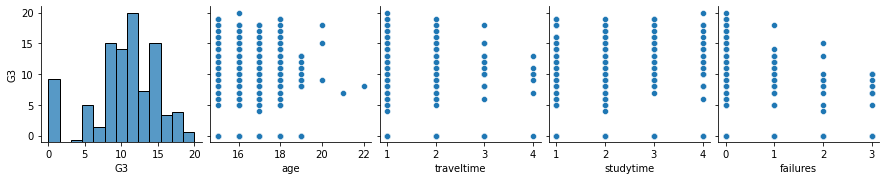

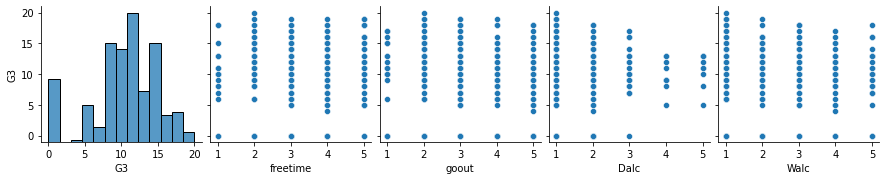

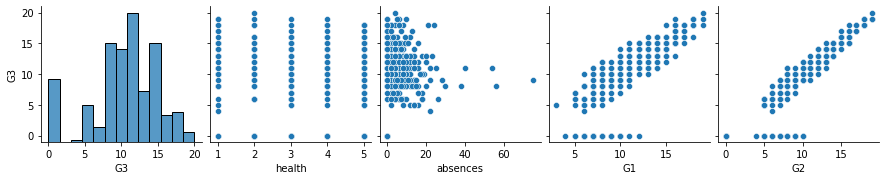

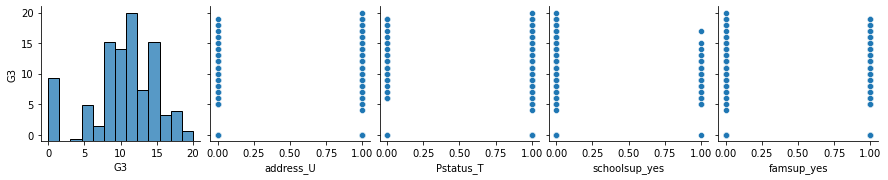

In [12]:
#Se muestra la correlación entre la calificación y las variables predictivas
for i in [0,4,8,12]:
    sns.pairplot(data=datos,
                  y_vars=['G3'],
                  x_vars=['G3',X.columns[i], X.columns[i+1], X.columns[i+2],X.columns[i+3]])
    plt.show()
#No se muestran las gráficas de las columnas con variables dummies

In [13]:
## 4) DIVIDIR LOS DATOS
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size = 0.2,random_state = 1)

### Regresión Lineal Múltiple

In [14]:
## 5) CONSTRUIR UN MODELO
# En este ejemplo vamos a elegir un modelo de regresión lineal simple para "X_train"
regresor = LinearRegression()
regresor.fit(X_train, Y_train)

LinearRegression()

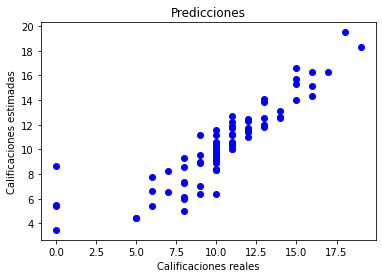

In [15]:
## 6) PREDICCIONES
# Se hacen las predicciones con "X_test"
Y_pred_lin = regresor.predict(X_test)

# Se grafican los resultados de la predicción.
plt.scatter(Y_test, Y_pred_lin, color = 'blue')
plt.title('Predicciones')
plt.xlabel('Calificaciones reales')
plt.ylabel('Calificaciones estimadas')
plt.show()

In [16]:
#Se imprimen los valores de los coeficientes
print(pd.Series(regresor.coef_, index = X.columns)) # Valor de los coeficientes

age              -0.240013
traveltime        0.141455
studytime        -0.072080
failures         -0.193124
freetime          0.152462
goout             0.177067
Dalc             -0.144627
Walc              0.000963
health            0.135445
absences          0.043515
G1                0.178493
G2                0.962256
address_U        -0.189219
Pstatus_T        -0.146340
schoolsup_yes     0.077598
famsup_yes       -0.040491
paid_yes          0.090156
activities_yes   -0.383212
internet_yes     -0.208685
romantic_yes     -0.344602
dtype: float64


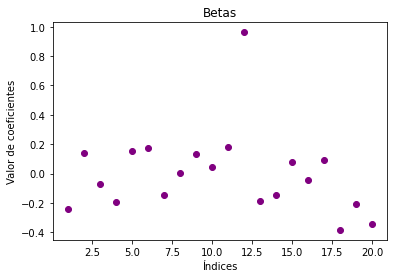

In [17]:
# Se grafican los valores de los coeficientes (betas).
eje_X = range(1,len(regresor.coef_)+1,1)
plt.scatter(eje_X, regresor.coef_, color = 'purple')
plt.title('Betas')
plt.xlabel('Índices')
plt.ylabel('Valor de coeficientes')
plt.show()

#### 7) EVALUACIÓN DEL MODELO
Veamos cómo se comporta el modelo:

7.1 Calcular $R^{2}$ ajustada $ = 1 - \dfrac{(1 - R^{2}) (n-1)}{n - p - 1}$, donde

$R^{2}:$ R cuadrada de los datos

$n:$ Número de datos para entrenar al modelo

$p:$ Número de variables independientes

7.2 Calcular los errores absolutos $(real - estimado)$ y graficarlos

7.3 Calcular los errores relativos $\left( \dfrac{\text{real - estimado}}{\text{real}} \right)$ y graficarlos

7.4 Graficar valores estimados vs valores reales

7.5 Calcular el error cuadrático: $(real − estimado)^{2}$

7.6 Calcular el error cuadrático medio: $\dfrac{\displaystyle \sum_{i = 1}^{n} (real_{i} − estimado_{i})^{2}}{n}$


In [18]:
#7.1 Calcular R^2 ajustada
r_cuad_lin = r2_score(Y_test,Y_pred_lin)
print('R^2 = ',round(r_cuad_lin,3))

#R^2 ajustada
n = len(Y_train)
p = X_train.shape[1]
r_cuad_aj_lin = 1 - (((1-r_cuad_lin)*(n-1))/(n-p-1))

print('n = ',n)
print('p = ',p)
print('R^2_aj = ',round(r_cuad_aj_lin,3))

R^2 =  0.769
n =  316
p =  20
R^2_aj =  0.753


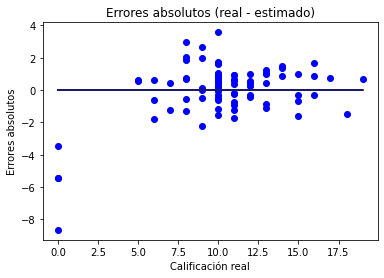

In [19]:
#7.2 Calcular los errores absolutos (real - estimado) y graficarlos
err_abs = Y_test-Y_pred_lin

plt.scatter(Y_test, err_abs, color = 'blue')
plt.plot(Y_test, np.zeros(len(err_abs)), color = 'midnightblue') #Recta en Y = 0
plt.title('Errores absolutos (real - estimado)')
plt.xlabel('Calificación real')
plt.ylabel('Errores absolutos')
plt.show()

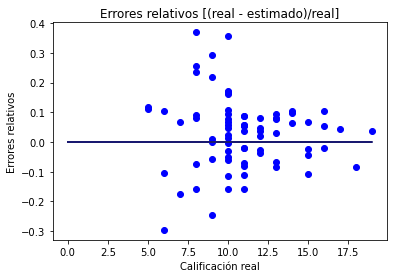

In [20]:
#7.3 Calcular los errores relativos [(real - estimado)/real] y graficarlos
err_rel = err_abs/Y_test

plt.scatter(Y_test, err_rel, color = 'blue')
plt.plot(Y_test, np.zeros(len(err_abs)), color = 'midnightblue') #Recta en Y = 0
plt.title('Errores relativos [(real - estimado)/real]')
plt.xlabel('Calificación real')
plt.ylabel('Errores relativos')
plt.show()

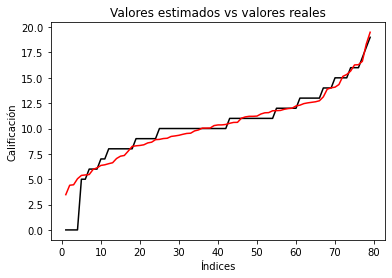

In [21]:
#7.4 Graficar valores estimados vs valores reales
eje_X = range(1,len(Y_test)+1)
plt.plot(eje_X, sorted(Y_test), color = 'black') #Recta de valores reales
plt.plot(eje_X, sorted(Y_pred_lin), color = 'red') #Recta de valores estimados
plt.title('Valores estimados vs valores reales')
plt.xlabel('Índices')
plt.ylabel('Calificación')
plt.show()

#Nota: Tanto los valores reales como los estimados se ordenaron de menor a mayor.

3.16


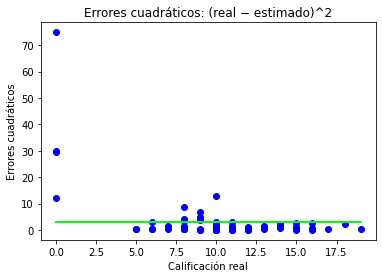

In [22]:
#7.5 Calcular el error cuadrático = (real − estimado)^2
#print(np.around(err_abs,2))
err_cuad = pow(err_abs,2)

#7.6 Calcular el error cuadrático medio = (1/n) * \sum (real − estimado)^2
ECM_lin = mean_squared_error(Y_test, Y_pred_lin)
print(round(ECM_lin,2))

#Graficamos los errores cuadráticos
Y_ECM= np.repeat(ECM_lin, len(err_cuad))
plt.scatter(Y_test, err_cuad, color = 'blue')
plt.plot(Y_test,Y_ECM , color = 'lime') #Recta en Y = err_cuad_medio
plt.title('Errores cuadráticos: (real − estimado)^2')
plt.xlabel('Calificación real')
plt.ylabel('Errores cuadráticos')
plt.show()

### LASSO

In [23]:
# Definimos el vector de lambdas, recordemos que el string 'lambda' está reservado para 
lambdas = 10**np.linspace(10,-2,100)*0.5

#Para estandarizar las variables el parámetro "normalize" es verdadero.
#Se define el máximo número de iteraciones en 10 mil
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for k in lambdas:
    lasso.set_params(alpha = k)
    lasso.fit(scale(X_train), Y_train)
    coefs.append(lasso.coef_)

np.shape(coefs)#Matriz con coeficientes asociadas a cada variable independiente y a cada valor de lambda

(100, 20)

In [24]:
## 5) CONSTRUIR UN MODELO
# Vamos a elegir lambda con "cross validation"
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, Y_train)

LassoCV(cv=10, max_iter=100000, normalize=True)

In [25]:
#Se imprimen los valores de los coeficientes
print(pd.Series(lassocv.coef_, index = X.columns)) # Valor de los coeficientes

age              -0.142744
traveltime        0.000000
studytime        -0.000000
failures         -0.036613
freetime          0.027715
goout             0.032685
Dalc             -0.000000
Walc              0.000000
health            0.037847
absences          0.023070
G1                0.162671
G2                0.941211
address_U        -0.000000
Pstatus_T        -0.000000
schoolsup_yes     0.000000
famsup_yes        0.000000
paid_yes          0.000000
activities_yes   -0.099034
internet_yes     -0.000000
romantic_yes     -0.158933
dtype: float64


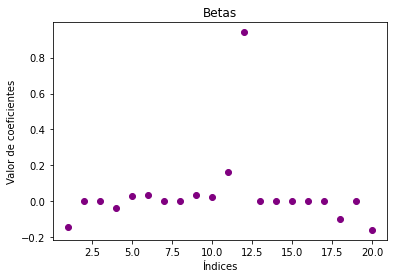

In [26]:
# Se grafican los valores de los coeficientes (betas).
eje_X = range(1,len(lassocv.coef_)+1,1)
plt.scatter(eje_X, lassocv.coef_, color = 'purple')
plt.title('Betas')
plt.xlabel('Índices')
plt.ylabel('Valor de coeficientes')
plt.show()

### Interpretación de los coeficientes

El valor de lambda encontrado con "cross validation" es:  0.006


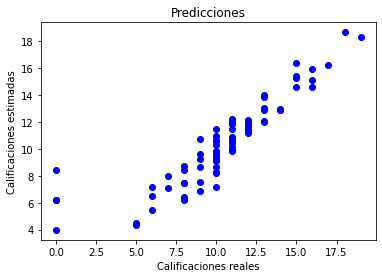

In [27]:
## 6) PREDICCIONES
# Se hacen las predicciones con "X_test"
lasso.set_params(alpha=lassocv.alpha_)
print('El valor de lambda encontrado con "cross validation" es: ',round(lassocv.alpha_,3))
lasso.fit(X_train, Y_train)
Y_pred_lasso = lasso.predict(X_test)

# Se grafican los resultados de la predicción.
plt.scatter(Y_test, Y_pred_lasso, color = 'blue')
plt.title('Predicciones')
plt.xlabel('Calificaciones reales')
plt.ylabel('Calificaciones estimadas')
plt.show()

#### 7) EVALUACIÓN DEL MODELO
Veamos cómo se comporta el modelo:

7.1 Calcular $R^{2}$ ajustada $ = 1 - \dfrac{(1 - R^{2}) (n-1)}{n - p - 1}$, donde

$R^{2}:$ R cuadrada de los datos

$n:$ Número de datos para entrenar al modelo

$p:$ Número de variables independientes

7.2 Calcular los errores absolutos $(real - estimado)$ y graficarlos

7.3 Calcular los errores relativos $\left( \dfrac{\text{real - estimado}}{\text{real}} \right)$ y graficarlos

7.4 Graficar valores estimados vs valores reales

7.5 Calcular el error cuadrático: $(real − estimado)^{2}$

7.6 Calcular el error cuadrático medio: $\dfrac{\displaystyle \sum_{i = 1}^{n} (real_{i} − estimado_{i})^{2}}{n}$


In [28]:
#7.1 Calcular R^2 ajustada
r_cuad_lasso = r2_score(Y_test,Y_pred_lasso)
print('R^2 = ',round(r_cuad_lasso,3))

#R^2 ajustada
n = len(Y_train)
p = X_train.shape[1]
r_cuad_aj_lasso = 1 - (((1-r_cuad_lasso)*(n-1))/(n-p-1))

print('n = ',n)
print('p = ',p)
print('R^2_aj = ',round(r_cuad_aj_lasso,3))

R^2 =  0.783
n =  316
p =  20
R^2_aj =  0.768


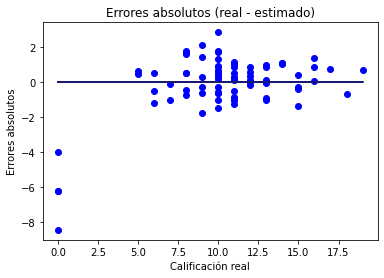

In [29]:
#7.2 Calcular los errores absolutos (real - estimado) y graficarlos
err_abs = Y_test-Y_pred_lasso

plt.scatter(Y_test, err_abs, color = 'blue')
plt.plot(Y_test, np.zeros(len(err_abs)), color = 'midnightblue') #Recta en Y = 0
plt.title('Errores absolutos (real - estimado)')
plt.xlabel('Calificación real')
plt.ylabel('Errores absolutos')
plt.show()

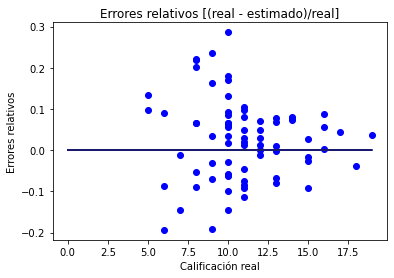

In [30]:
#7.3 Calcular los errores relativos [(real - estimado)/real] y graficarlos
err_rel = err_abs/Y_test

plt.scatter(Y_test, err_rel, color = 'blue')
plt.plot(Y_test, np.zeros(len(err_abs)), color = 'midnightblue') #Recta en Y = 0
plt.title('Errores relativos [(real - estimado)/real]')
plt.xlabel('Calificación real')
plt.ylabel('Errores relativos')
plt.show()

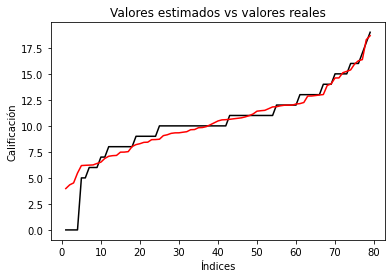

In [31]:
#7.4 Graficar valores estimados vs valores reales
eje_X = range(1,len(Y_test)+1)
plt.plot(eje_X, sorted(Y_test), color = 'black') #Recta de valores reales
plt.plot(eje_X, sorted(Y_pred_lasso), color = 'red') #Recta de valores estimados
plt.title('Valores estimados vs valores reales')
plt.xlabel('Índices')
plt.ylabel('Calificación')
plt.show()

#Nota: Tanto los valores reales como los estimados se ordenaron de menor a mayor.

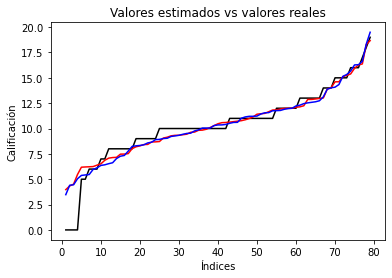

In [32]:
#7.4 Graficar valores estimados vs valores reales
eje_X = range(1,len(Y_test)+1)
plt.plot(eje_X, sorted(Y_test), color = 'black') #Recta de valores reales
plt.plot(eje_X, sorted(Y_pred_lasso), color = 'red') #Recta de valores estimados con LASSO
plt.plot(eje_X, sorted(Y_pred_lin), color = 'blue') #Recta de valores estimados con regresión lineal múltiple
plt.title('Valores estimados vs valores reales')
plt.xlabel('Índices')
plt.ylabel('Calificación')
plt.show()

2.97


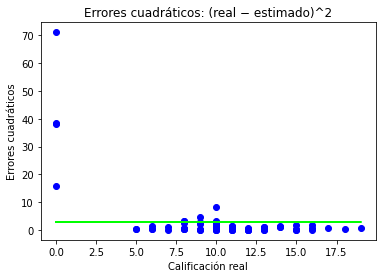

In [33]:
#7.5 Calcular el error cuadrático = (real − estimado)^2
#print(np.around(err_abs,2))
err_cuad = pow(err_abs,2)

#7.6 Calcular el error cuadrático medio = (1/n) * \sum (real − estimado)^2
ECM_lasso = mean_squared_error(Y_test, Y_pred_lasso)
print(round(ECM_lasso,2))

#Graficamos los errores cuadráticos
Y_ECM= np.repeat(ECM_lasso, len(err_cuad))
plt.scatter(Y_test, err_cuad, color = 'blue')
plt.plot(Y_test,Y_ECM , color = 'lime') #Recta en Y = err_cuad_medio
plt.title('Errores cuadráticos: (real − estimado)^2')
plt.xlabel('Calificación real')
plt.ylabel('Errores cuadráticos')
plt.show()

### Conclusiones

In [34]:
print("Regresión Lineal Múltiple:")
print("R^2 ajustada = ",round(r_cuad_aj_lin,3),"  ECM = ",round(ECM_lin,3))

print("\nLASSO:")
print("R^2 ajustada = ",round(r_cuad_aj_lasso,3),"  ECM = ",round(ECM_lasso,3))

Regresión Lineal Múltiple:
R^2 ajustada =  0.753   ECM =  3.158

LASSO:
R^2 ajustada =  0.768   ECM =  2.967


Al comparar ambos modelos con el error cuadrático medio y con $R^{2}$ ajustada, se elige _LASSO Regression_.

Las variables que se hicieron cero en LASSO son:

     - traveltime
     - studytime
     - Dalc
     - Walc
     - address_U
     - Pstatus_T
     - schoolsup_yes
     - famsup_yes
     - paid_yes
     - internet_yes



## ¿Qué se puede decir de dichos resultados?

## ¿Qué otras variables se podrían agregar al modelo?

     - school
     - sex
     - famsize
     - Medu
     - Fedu
     - Mjob
     - Fjob
     - reason
     - guardian
     - nursery
     - higher
     - famrel

In [35]:
# Se define un nuevo dataframe:
X2 = df[['school','sex','famsize','Medu','Fedu','Mjob','Fjob','reason','guardian','nursery',
    'age','romantic','higher','famrel','G1','G2']]

print(X2.shape)
X2.head()

(395, 16)


,school,sex,famsize,Medu,Fedu,Mjob,Fjob,reason,guardian,nursery,age,romantic,higher,famrel,G1,G2
0,GP,F,GT3,4,4,at_home,teacher,course,mother,yes,18,no,yes,4,5,6
1,GP,F,GT3,1,1,at_home,other,course,father,no,17,no,yes,5,5,5
2,GP,F,LE3,1,1,at_home,other,other,mother,yes,15,no,yes,4,7,8
3,GP,F,GT3,4,2,health,services,home,mother,yes,15,yes,yes,3,15,14
4,GP,F,GT3,3,3,other,other,home,father,yes,16,no,yes,4,6,10


In [36]:
#Se definen las variables dummies para las variables categóricas
dummies = pd.get_dummies(X2[['school', 'sex','famsize','Mjob','Fjob','reason','guardian','nursery','romantic','higher']])
dummies.head()

,school_GP,school_MS,sex_F,sex_M,famsize_GT3,famsize_LE3,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,nursery_no,nursery_yes,romantic_no,romantic_yes,higher_no,higher_yes
0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1
1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1
2,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1
3,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1
4,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1


In [37]:
#Se reemplazan por las variables dummies
X2 = X2.drop(['school', 'sex','famsize','Mjob','Fjob','reason','guardian','nursery','romantic',
              'higher'], axis = 1).astype('float64')
X2 = pd.concat([X2, dummies[['school_GP','sex_F','famsize_GT3',
                             'Mjob_at_home','Mjob_health','Mjob_services','Mjob_teacher',
                             'Fjob_at_home','Fjob_health','Fjob_services','Fjob_teacher',
                             'reason_course','reason_home','reason_reputation',
                             'guardian_father','guardian_mother','nursery_yes','romantic_yes','higher_yes']]], axis = 1)
X2.head()

,Medu,Fedu,age,famrel,G1,G2,school_GP,sex_F,famsize_GT3,Mjob_at_home,Mjob_health,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_reputation,guardian_father,guardian_mother,nursery_yes,romantic_yes,higher_yes
0,4.0,4.0,18.0,4.0,5.0,6.0,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1
1,1.0,1.0,17.0,5.0,5.0,5.0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
2,1.0,1.0,15.0,4.0,7.0,8.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
3,4.0,2.0,15.0,3.0,15.0,14.0,1,1,1,0,1,0,0,0,0,1,0,0,1,0,0,1,1,1,1
4,3.0,3.0,16.0,4.0,6.0,10.0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1


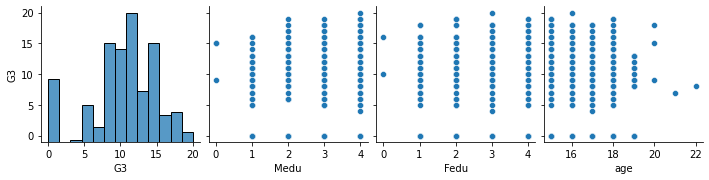

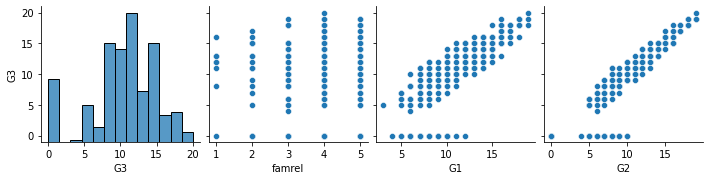

In [38]:
#Se muestra la correlación entre la calificación y las variables predictivas
for i in [0,3]:
    sns.pairplot(data=df,
                  y_vars=['G3'],
                  x_vars=['G3',X2.columns[i], X2.columns[i+1], X2.columns[i+2]])
    plt.show()
    
#No se muestran las gráficas de las columnas con variables dummies

In [39]:
## 4) DIVIDIR LOS DATOS
X_train, X_test, Y_train, Y_test = train_test_split(X2, Y,test_size = 0.2,random_state = 0)

### Ridge Regression

In [40]:
## 5) CONSTRUIR UN MODELO
#Le pasamos como parámetro el vector con los diferentes valores de lambda para que
#se elija la mejor con "cross validation"
ridgecv = RidgeCV(alphas = lambdas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, Y_train)
print('El valor de lambda encontrado con "cross validation" es: ',round(ridgecv.alpha_,3))

El valor de lambda encontrado con "cross validation" es:  0.012


In [41]:
#Verificamos que el valor encontrado está en el vector de lambdas
ridgecv.alpha_ in lambdas

True

In [42]:
#Se imprimen los valores de los coeficientes
mod_ridgeCV = Ridge(alpha = ridgecv.alpha_, normalize = True)
mod_ridgeCV.fit(X_train, Y_train)
print(pd.Series(mod_ridgeCV.coef_, index = X2.columns)) # Valor de los coeficientes

Medu                 0.212709
Fedu                -0.172697
age                 -0.192638
famrel               0.185346
G1                   0.157721
G2                   0.939265
school_GP           -0.274507
sex_F               -0.138557
famsize_GT3         -0.257427
Mjob_at_home        -0.031802
Mjob_health         -0.242501
Mjob_services       -0.070157
Mjob_teacher        -0.190974
Fjob_at_home        -0.437360
Fjob_health          0.402846
Fjob_services       -0.033327
Fjob_teacher        -0.263065
reason_course       -0.413236
reason_home         -0.653373
reason_reputation   -0.562566
guardian_father      0.045388
guardian_mother      0.164391
nursery_yes         -0.105663
romantic_yes        -0.268556
higher_yes           0.655299
dtype: float64


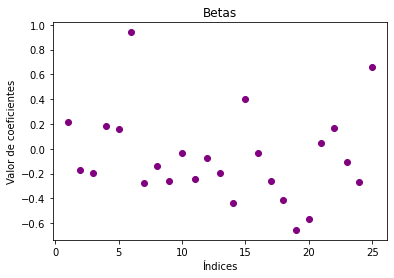

In [43]:
# Se grafican los valores de los coeficientes (betas).
eje_X = range(1,len(mod_ridgeCV.coef_)+1,1)
plt.scatter(eje_X, mod_ridgeCV.coef_, color = 'purple')
plt.title('Betas')
plt.xlabel('Índices')
plt.ylabel('Valor de coeficientes')
plt.show()

### Interpretación de los coeficientes

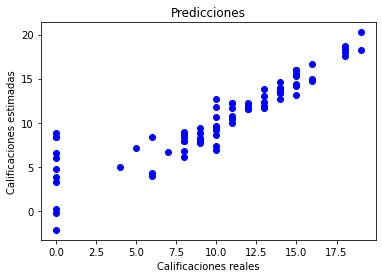

In [44]:
## 6) PREDICCIONES
Y_pred_ridge = mod_ridgeCV.predict(X_test)

# Se grafican los resultados de la predicción.
plt.scatter(Y_test, Y_pred_ridge, color = 'blue')
plt.title('Predicciones')
plt.xlabel('Calificaciones reales')
plt.ylabel('Calificaciones estimadas')
plt.show()

In [45]:
## 7) EVALUACIÓN DEL MODELO

#7.1 Calcular R^2 ajustada
r_cuad_ridge = r2_score(Y_test,Y_pred_ridge)
print('R^2 = ',round(r_cuad_ridge,3)) #Porcentaje de los datos explicados por el modelo

#R^2 ajustada
n = len(Y_train)
p = X_train.shape[1]
r_cuad_aj_ridge = 1 - (((1-r_cuad_ridge)*(n-1))/(n-p-1))

print('n = ',n)
print('p = ',p)
print('R^2_aj = ',round(r_cuad_aj_ridge,3))

#Calculamos el error cuadrático medio: $\dfrac{\displaystyle \sum_{i = 1}^{n} (real_{i} − estimado_{i})^{2}}{n}$
ECM_ridge = round(mean_squared_error(Y_test, Y_pred_ridge),3) 
print(ECM_ridge)

R^2 =  0.801
n =  316
p =  25
R^2_aj =  0.784
5.496


In [46]:
print("Regresión Lineal Múltiple:")
print("R^2 ajustada = ",round(r_cuad_aj_lin,3),"  ECM = ",round(ECM_lin,3))

print("\nLASSO:")
print("R^2 ajustada = ",round(r_cuad_aj_lasso,3),"  ECM = ",round(ECM_lasso,3))

print("\nRidge:")
print("R^2 ajustada = ",round(r_cuad_aj_ridge,3),"  ECM = ",round(ECM_ridge,3))

Regresión Lineal Múltiple:
R^2 ajustada =  0.753   ECM =  3.158

LASSO:
R^2 ajustada =  0.768   ECM =  2.967

Ridge:
R^2 ajustada =  0.784   ECM =  5.496


## Combinación lineal de las predicciones

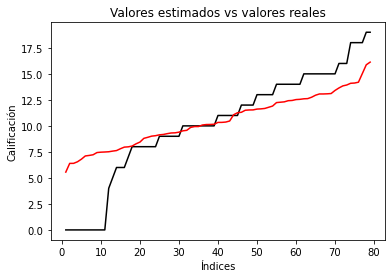

In [47]:
Y_pred_1 = (0.4*Y_pred_ridge) + (0.6*Y_pred_lasso) + (0*Y_pred_lin)

# Valores estimados vs valores reales
eje_X = range(1,len(Y_test)+1)
plt.plot(eje_X, sorted(Y_test), color = 'black') #Recta de valores reales
plt.plot(eje_X, sorted(Y_pred_1), color = 'red') #Recta de valores estimados
plt.title('Valores estimados vs valores reales')
plt.xlabel('Índices')
plt.ylabel('Calificación')
plt.show()
#Nota: Tanto los valores reales como los estimados se ordenaron de menor a mayor.

In [48]:
## 7) EVALUACIÓN DEL MODELO
#Calculamos el error cuadrático medio: $\dfrac{\displaystyle \sum_{i = 1}^{n} (real_{i} − estimado_{i})^{2}}{n}$
ECM_1 = round(mean_squared_error(Y_test, Y_pred_1),3) 
print(ECM_1)

20.0


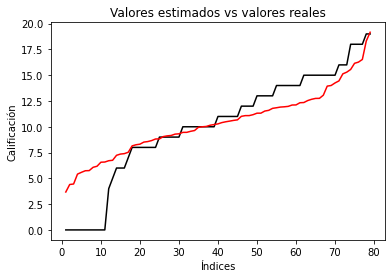

In [49]:
Y_pred_2 = (0*Y_pred_ridge) + (0.4*Y_pred_lasso) + (0.6*Y_pred_lin)

# Valores estimados vs valores reales
eje_X = range(1,len(Y_test)+1)
plt.plot(eje_X, sorted(Y_test), color = 'black') #Recta de valores reales
plt.plot(eje_X, sorted(Y_pred_2), color = 'red') #Recta de valores estimados
plt.title('Valores estimados vs valores reales')
plt.xlabel('Índices')
plt.ylabel('Calificación')
plt.show()
#Nota: Tanto los valores reales como los estimados se ordenaron de menor a mayor.

In [50]:
## 7) EVALUACIÓN DEL MODELO
#Calculamos el error cuadrático medio: $\dfrac{\displaystyle \sum_{i = 1}^{n} (real_{i} − estimado_{i})^{2}}{n}$
ECM_2 = round(mean_squared_error(Y_test, Y_pred_2),3) 
print(ECM_2)

43.63


In [51]:
Y_pred_3 = (0.5*Y_pred_ridge) + (0.4*Y_pred_lasso) + (0.1*Y_pred_lin)

In [52]:
## 7) EVALUACIÓN DEL MODELO
#Calculamos el error cuadrático medio: $\dfrac{\displaystyle \sum_{i = 1}^{n} (real_{i} − estimado_{i})^{2}}{n}$
ECM_3 = round(mean_squared_error(Y_test, Y_pred_3),3) 
print(ECM_3)

16.004


### Encontremos los pesos óptimos minimizando el error cuadrático medio

In [53]:
#Se define una función que calcula los pesos para la combinación lineal de los modelos
def objective(weights,train_predictions,y_train):
    y_ens = np.average(train_predictions, axis=1, weights=weights)
    return mean_squared_error(y_train, y_ens)

In [54]:
#Se define una matriz con los valores de las predicciones de los modelos
train_predictions = np.concatenate([Y_pred_ridge[:, None],
                                    Y_pred_lasso[:, None],
                                    Y_pred_lin[:,None]], axis=1)

#Se definen los pesos iniciales
w0 = [0.2,0.5,0.3]

#Se definen las cotas para los pesos (deben de estar entre 0 y 1)
bounds = [(0,1)] * train_predictions.shape[1]

#Se definen las restirrciones: La suma de los pesos debe de ser igual a 1
cons = [{'type': 'eq','fun': lambda w: w.sum() - 1}]

In [55]:
#Se utiliza la función "minimize" para minimizar la función objetivo (minimizar el ECM)
#El método "SLSQP" permite definir restricciones
res = minimize(objective,
               w0,
               args = (train_predictions,Y_test),
               method='SLSQP',
               bounds=bounds,
               options={'disp':True, 'maxiter':10000},
               constraints=cons)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.495848531283008
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2


In [56]:
pesos_opt = res.x

In [57]:
print('\nPesos Óptimos:')
print('Ridge: {:.4f}'.format(pesos_opt[0]))
print('LASSO: {:.4f}'.format(pesos_opt[1]))
print('Regresión Lineal: {:.4f}'.format(pesos_opt[2]))


Pesos Óptimos:
Ridge: 1.0000
LASSO: 0.0000
Regresión Lineal: 0.0000


In [58]:
Y_pred_4 = (pesos_opt[0]*Y_pred_ridge) + (pesos_opt[1]*Y_pred_lasso) + (pesos_opt[2]*Y_pred_lin)

## 7) EVALUACIÓN DEL MODELO
#Calculamos el error cuadrático medio: $\dfrac{\displaystyle \sum_{i = 1}^{n} (real_{i} − estimado_{i})^{2}}{n}$
ECM_4 = round(mean_squared_error(Y_test, Y_pred_4),3) 
print(ECM_4)

5.496


## Conclusiones

In [59]:
print("Regresión Lineal Múltiple:")
print("R^2 ajustada = ",round(r_cuad_aj_lin,3),"  ECM = ",round(ECM_lin,3))

print("\nLASSO:")
print("R^2 ajustada = ",round(r_cuad_aj_lasso,3),"  ECM = ",round(ECM_lasso,3))

print("\nRidge:")
print("R^2 ajustada = ",round(r_cuad_aj_ridge,3),"  ECM = ",round(ECM_ridge,3))

print("\nCombinación lineal 1:")
print("ECM = ",round(ECM_1,3))

print("\nCombinación lineal 2:")
print("ECM = ",round(ECM_2,3))

print("\nCombinación lineal 3:")
print("ECM = ",round(ECM_3,3))

print("\nCombinación lineal óptima:")
print("ECM = ",round(ECM_4,3))

Regresión Lineal Múltiple:
R^2 ajustada =  0.753   ECM =  3.158

LASSO:
R^2 ajustada =  0.768   ECM =  2.967

Ridge:
R^2 ajustada =  0.784   ECM =  5.496

Combinación lineal 1:
ECM =  20.0

Combinación lineal 2:
ECM =  43.63

Combinación lineal 3:
ECM =  16.004

Combinación lineal óptima:
ECM =  5.496


## ¿Qué se concluye de estos resultados?